<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-Daily/blob/main/Titanic_dataset_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is the one I used as part of the [Titanic: Machine Learning from Disaster, Kaggle Competition](https://www.kaggle.com/c/titanic). <br>
In this competition, the <b>goal</b> is to perform a 2-label <b>classification problem</b>: predict which <b>passengers survived</b> the tragedy. <br> [Kaggle](https://www.kaggle.com) offers two datasets. One training (the labels are known) and one testing (the labels are unknown)  for which we can submit a file with our predicted labels. <br>
We have access to a bunch of 9 features (numerical, text, categorical). The <b>big challenge</b> with this competition is the size of the data we have. The <b>training set</b> is composed of only <b>891 samples</b>. The testing set is composed of 418 samples. <br>Therefore, the main issue is to design an algorithm which generalize enough in order to avoid <b>over-fitting</b>. To do so, a bunch of generalized enough features is generated. Then, an ensemble modeling method with voting is used in order to get the most generalized model.<br><br>
The framework of this notebook is:
- Preliminary Work:
    - Exploration
    - NaN values
    - Exploration
- Analysis of the features
    - Categorical and Integer Numerical
    - Numerical
- Feature Engineering
- Modeling
    - Simple Models & Selection
    - Hyper-Parameters Optimization 
    - Ensemble Modeling
- Submission

In [ ]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt

%matplotlib inline


from pandas import DataFrame
from scipy.stats import boxcox
from matplotlib import pyplot


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from xgboost import XGBClassifier




from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix




from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier



from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV


from tqdm import tqdm


from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# Preliminary work

In this part, I do some explorations and understanding of the data.

## General exploration

In [ ]:
#dataframe provided by Kaggle - the one with the labels
df = pd.read_csv('./data/'+ 'train.csv')
#dataframe provided by Kaggle - the one without the labels -> we have to predict the labels
df_test = pd.read_csv('./data/'+ 'test.csv')

In [ ]:
print(df.columns)
print(df_test.columns)
print('number of features', len(df_test.columns))

Index(['Survived', 'Pclass', 'Age', 'Fare', 'cat_male', 'cat_Q', 'cat_S',
       'cat_Miss', 'cat_Mr', 'cat_Mrs', 'cat_Other', 'cat_big', 'cat_small',
       'cat_Prefix_1', 'cat_Prefix_2', 'cat_Cab_1', 'cat_Cab_2'],
      dtype='object')
Index(['Pclass', 'Age', 'Fare', 'cat_male', 'cat_Q', 'cat_S', 'cat_Miss',
       'cat_Mr', 'cat_Mrs', 'cat_Other', 'cat_big', 'cat_small',
       'cat_Prefix_1', 'cat_Prefix_2', 'cat_Cab_1', 'cat_Cab_2'],
      dtype='object')
number of features 16


The column 'Survived' is the label. This is the variable to predict. <br>
This column is present in the training dataset but not in the testing: for sure it's the one we need to predict!

In [ ]:
print(len(df), 'records for the training dataset.')
print(len(df_test), 'records for the testing dataset. ')

891 records for the training dataset.
418 records for the testing dataset. 


In [ ]:
survivors = df.Survived.sum()
unsurvivors = len(df) - survivors

print( survivors, 'people survived.')
print( unsurvivors, 'people did not survive.')

342 people survived.
549 people did not survive.


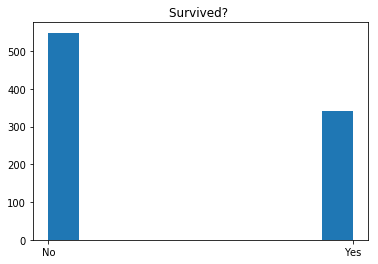

In [ ]:
plt.hist(df.Survived)
plt.title('Survived? ')
plt.xticks(np.arange(2), ('No', 'Yes'))
plt.show()

## NaN values

In [ ]:
print(df.isnull().sum())
print('-----------')
print('-----------')
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------
-----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


From the records, we can see that 4 features have missing values:
- Age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 -> Numerical Variable
- Cabin: Cabin number -> Categorical variable
- Embarked: Port of Embarkation (3 categories)  -> Categorical variable
- Fare: Numerical: Only 1 missing in the test dataset. Can be replace by the mean in the training set. 

### Embarked

'Embarked' is only missing 2 data among all the training set and no-one in the test set. Because of its categorical nature, we would have create a new 'missing_value' category. However, here, we'll just replace the missing by the majority category.

### Cabin

In [ ]:
print(df.Cabin.isnull().sum() / len(df))

0.7710437710437711


Almost 80% of the Cabin data is missing. That probably means only 20% of the passengers had a cabin. This feature should be dropped. However, let's explore later if the feature brings some informations.

### Age

In [ ]:
print(df.Age.isnull().sum() / len(df))

0.19865319865319866


Only 20% of the age data is missing. So, we need to fill the missing values. To do so, we can apply different methodologies:
- Take the mean of the age values
- Take random number with a normal law N(mean, std deviation) of the age
- Split the people in smaller group and then take the mean of these subgroups using categorical features - > the one I chose.
- Split the people in smaller group and then take random number with a normal law N(mean, std deviation) of the age within each subgroup

We'll use the third one. 

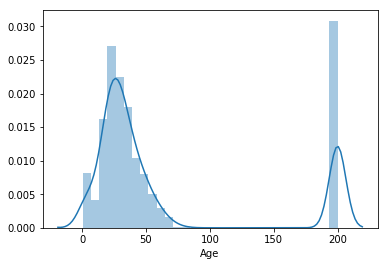

In [ ]:
sns.distplot(df.Age.fillna(200))

For visualization, we plot here the distribution of the age in the boat. We filled the missing value by 200 in order to be able to visualize them too. 

## Feature Exploration

In [ ]:
list_features = df_test.columns
print('They are',len(list_features),'features in the dataset.')
print('----------------')
for f in list_features:
    print('feature:', f, '|| Type:', type(df[f][0]), '|| Example:', df[f][0], '|| number of unique values', len(df[f].unique()) )

They are 11 features in the dataset.
----------------
feature: PassengerId || Type: <class 'numpy.int64'> || Example: 1 || number of unique values 891
feature: Pclass || Type: <class 'numpy.int64'> || Example: 3 || number of unique values 3
feature: Name || Type: <class 'str'> || Example: Braund, Mr. Owen Harris || number of unique values 891
feature: Sex || Type: <class 'str'> || Example: male || number of unique values 2
feature: Age || Type: <class 'numpy.float64'> || Example: 22.0 || number of unique values 89
feature: SibSp || Type: <class 'numpy.int64'> || Example: 1 || number of unique values 7
feature: Parch || Type: <class 'numpy.int64'> || Example: 0 || number of unique values 7
feature: Ticket || Type: <class 'str'> || Example: A/5 21171 || number of unique values 681
feature: Fare || Type: <class 'numpy.float64'> || Example: 7.25 || number of unique values 248
feature: Cabin || Type: <class 'float'> || Example: nan || number of unique values 148
feature: Embarked || Type: <

The dataset proposes 11 features:
- PassengerId: This is a number automatically attributed to each passenger: we can get ride of it.
- Pclass: This is an ordered categorical variable. Indeed, there is a relationship between classes. 1 > 2 > 3. To allow model to uncover relation, we can code it with numerical values which reflects the order. This methods is so-called polynomial contrast (see the amazing [class](http://www.feat.engineering/encoding-categorical-predictors.html#tab:categorical-ordered-table) and you can see here the [table](http://users.stat.ufl.edu/~winner/tables/orthpol.pdf) for linear and quadratic polynomial.
- Name: This is a string. The name is like an idea, a unique identifier (as much name as IDs). We can't use the raw name as a feature. We can see that the title is present in the middle of the name. This can be extracted to engineer a new feature. 
- Sex: Two categories. Because there is no order between the 2, we can encode it using [one-hot encoding](https://fr.wikipedia.org/wiki/Encodage_one-hot).
- Age: Numerical values, we can keep it as numerical or group them in sub-groups. But first, we'll need to fill the N/A values. 
- SibSp: number of sibling/spouse on board. Integer values, let's see after. 
- Parch: number of parent/children on board. Integer values, let's see after.
- Ticket: Ticket number. There is less ticket numbers than IDs. Let's observe it later.
- Fare: Fare of the ticket. Numerical value.
- Cabin: Let's see later. 
- Embarked: Port of embarkation. There are 4 values (one is missing, we'll get ride of the 2 missing rows). There is no order between the port. Let's encode it with [one-hot encoding](https://fr.wikipedia.org/wiki/Encodage_one-hot).

# Analysis 

## Categorical and Integer Numerical

Let's observe the survival of people following the categorical features. 

In [ ]:
df[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


It seems that the more you are in a upper class, the more you are likely to survive. 

In [ ]:
df[['Sex', 'Survived']].groupby('Sex').mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


Being a female gives a lot of chance to survive compare to male. 

In [ ]:
df[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Being from Cherbourg is a factor a survival. Southampton decreases your chance of survival. This is surprising! 

In [ ]:
df[['Embarked', 'Pclass']].groupby('Embarked').mean().sort_values(by='Pclass', ascending=False)

,Pclass
Embarked,
Q,2.909091
S,2.350932
C,1.886905


We can see that people from Cherbourg were more settled in the Class 1. This can be an explanation. 

In [ ]:
title_mapping = {"male": 1, "female": 0}
df_ = df.copy()
df_['Sex'] = df_['Sex'].map(title_mapping)
print(df_[['Embarked', 'Sex']].groupby('Embarked').mean().sort_values(by='Sex', ascending=False))
del(df_)

               Sex
Embarked          
S         0.684783
C         0.565476
Q         0.532468


The low survival of S can be explained by the high-rate of men. 

In [ ]:
df[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [ ]:
df[["Parch", "Survived"]].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


Having a lot of family makes you less likely to survive. Let's engineer this feature later!

<u>Conclusion:</u>
- Pclass and Sex has a great correlation with the survival of people -> Keep them as features
- SibSp & Parch require engineering. 
- Embarked: I have some doubts on the correlation between survival and Embarked. I think the observed correlation is [spurious](https://en.wikipedia.org/wiki/Spurious_relationship) and more due to third party factors (such as passenger class or sex). We'll need to try the model with/without this feature which will be encoded as one-hot. 

## Numerical

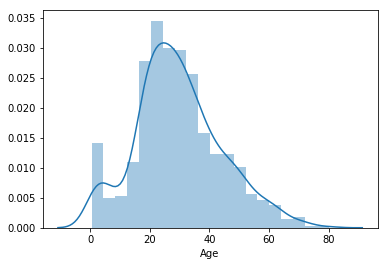

In [ ]:
sns.distplot(df.Age.dropna())

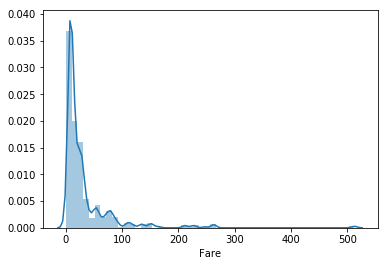

In [ ]:
sns.distplot(df.Fare.dropna())

The distribution of fare especially is highly skewed. We can use Box-Cox transform in order to rescale the data. 

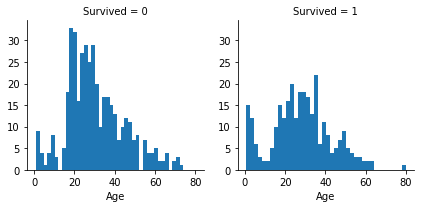

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Age', bins=40))


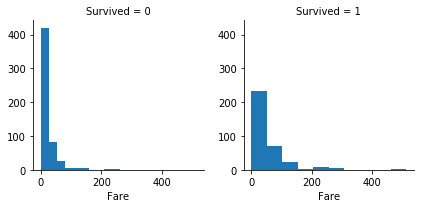

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Fare', bins=10))

<u>Conclusion:</u>
- Younger and older people survived.
- The middle age (20-40) people did not survive. 
- We should consider the age as predicator

- Fare is less clear

# Feature engineering

In this part, we engineer the features in order to feed the predictive model. 

## PassengerId

As said, we get ride of it.

In [ ]:
df.drop('PassengerId', axis = 1, inplace = True)
df_test.drop('PassengerId', axis = 1, inplace = True)

## Pclass

Because of the ordered label of this class, we use the orthogonal polynom. Most of the time, we can use 2 types (linear and quadratic). Here the ordering in survival rate (1>2>3) makes us choosing the linear order. 

In [ ]:
mapping_pclass = {1:1, 2:0, 3:-1}
df['Pclass'] = df['Pclass'].map(mapping_pclass)
df_test['Pclass'] = df_test['Pclass'].map(mapping_pclass)

## Name

As seen previously, we can get the people's title from the name. 

In [ ]:
example = df.Name[98]
example

'Doling, Mrs. John T (Ada Julia Bone)'

In [ ]:
def get_title(var):
    """
    This function takes as input the name and returns the title of the people. 
    
    """
    title = var.split(',')[1]
    title2 = title.split('.')[0]
    return title2[1:]

In [ ]:
#create the title colmun

df['Title'] = df.apply(lambda x: get_title(x.Name), axis = 1)
df_test['Title'] = df_test.apply(lambda x: get_title(x.Name), axis = 1)

In [ ]:
print(df.groupby('Title').count().sort_values(by='Survived', ascending=False)['Pclass'])
print('-------------')
print('-------------')
print(df_test.groupby('Title').count().sort_values(by='Name', ascending=False)['Pclass'])

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: Pclass, dtype: int64
-------------
-------------
Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
Name: Pclass, dtype: int64


There is a majority of men. <br>
However, many labels are few represented. Let's group them into a global label.


In [ ]:
#mapping of the title
#the mapping is defined with the following dictionnary 

title_map = {'Mlle':'Miss','Ms':'Miss','Mlle':'Miss', 
             'Mme':'Mrs', 
             'Dr':'Other','Rev':'Other', 'Major':'Other', 'Col':'Other', 'Sir':'Other', 'Dona':'Other',
             'Capt':'Other', 'Lady':'Other','Jonkheer':'Other', 'Don':'Other', 'the Countess':'Other',
            'Mr':'Mr',
            'Miss':'Miss',
            'Mrs':'Mrs',
            'Master':'Master'}

df['Title'] = df['Title'].map(title_map)
df_test['Title'] = df_test['Title'].map(title_map)

df.drop('Name', axis=1, inplace = True)
df_test.drop('Name', axis=1, inplace = True)

In [ ]:
df[['Title', 'Survived']].groupby('Title').mean().sort_values(by='Survived', ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575000
Other,0.347826
Mr,0.156673


Then, we'll encode the variable using one-hot encoding later. 

Let's check if the coding worked. 

In [ ]:
print(df.groupby(['Sex', 'Title']).count().Pclass)
print('---------------')
print('---------------')
print(df_test.groupby(['Sex', 'Title']).count().Pclass)


Sex     Title 
female  Miss      185
        Mrs       126
        Other       3
male    Master     40
        Mr        517
        Other      20
Name: Pclass, dtype: int64
---------------
---------------
Sex     Title 
female  Miss       79
        Mrs        72
        Other       1
male    Master     21
        Mr        240
        Other       5
Name: Pclass, dtype: int64


So, we don't have wrong title (example: a female labeled as Mr.) 

## Sex

Nothing to do, let's just encode it later. 

## Age

Recall: There is a lot of missing value (20% of the dataset) so we need to fill these NaNs. We will use the categorical variables to get the mean for each subgroup and then use it to fill NaNs. 

To do so, we can use all the data we have access and so both training and testing data. To avoid data leakage from the test set, we fill in missing ages in the train using the train set and we fill in ages in the test set using values calculated from the train set as well.

In [ ]:
#these are the used categorical features

cat = ['Sex', 'Pclass', 'Title']



#this dataframe contains the age and the categorical values 
df_age = df[cat + ['Age']].append(df_test[cat + ['Age']])

In [ ]:
#This dataframe enables us to compute the average age in function of the categorical variables 

df_age_mean = round(df_age.dropna().groupby(cat, as_index=True).median(),1)

def get_age(var, sex, pclass, title):
    """
    This function takes as input the categorical variables 
    and it returns the average age given the categorical variables 
    
    """
    if np.isnan(var):
        mean = df_age_mean['Age'][sex][pclass][title]
    else:
        mean = var
    return mean

In [ ]:
df_age['Age2'] = df_age.apply(lambda x: get_age(x.Age, x.Sex, x.Pclass, x.Title), axis=1)

In [ ]:
df_age.isnull().sum()

Sex         0
Pclass      0
Title       0
Age       263
Age2        0
dtype: int64

So, we filled every NaN values. Let's fill the df and df_test. 

In [ ]:
#filling the original dataframes
df['Age'] = df.apply(lambda x: get_age(x.Age, x.Sex, x.Pclass, x.Title), axis=1)
df_test['Age'] = df_test.apply(lambda x: get_age(x.Age, x.Sex, x.Pclass, x.Title), axis=1)


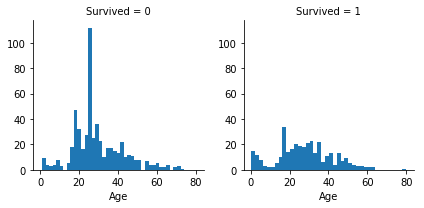

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Age', bins=40))

Remark: A majority of the attributed age have been attributed to the 28.3 age.

The curve is skewed. Let's use [Box-Cox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) transform to map the data to a Normal distribution. <br>
Thanks to [Jason Brownlee](https://machinelearningmastery.com/about/) for its amazing [tutorial](https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/).

Lambda: 0.764108


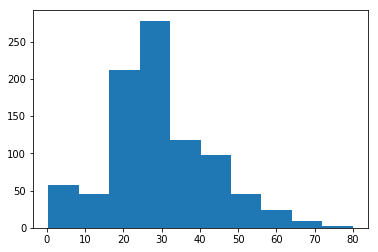

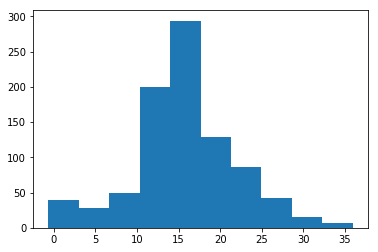

In [ ]:
#we use the training dataset to estimate the box cox coefficient

df['Age2'], lam_age = boxcox(df['Age'])
print('Lambda: %f' % lam_age)

# histogram
pyplot.hist(df['Age'])
pyplot.show()

pyplot.hist(df['Age2'])
pyplot.show()

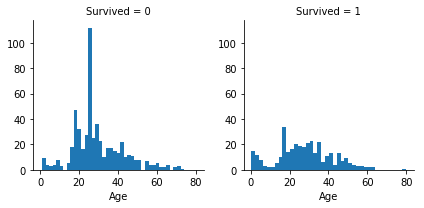

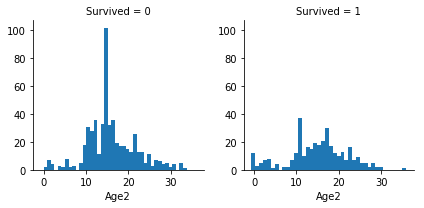

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Age', bins=40))
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Age2', bins=40))

In [ ]:
df.drop(['Age2'], axis=1, inplace= True)

In [ ]:
#here we apply the box-cox transformation to the 2 datasets

def get_transform(var):
    return (var**lam_age - 1) / lam_age

df['Age'] = df.apply(lambda x: get_transform(x.Age),axis=1)
df_test['Age'] = df_test.apply(lambda x: get_transform(x.Age),axis=1)


## Parch & SibSp

We saw previously that we needed to perform transformation on these 2 series. Let's design new features:
- Size of the Family: the number of on-board family members 
- isAlone: dummy equal to one if the passenger travels alone

In [ ]:
def get_family_size(Parch, SibSp):
    """
    Return the size of the family 
    
    +1 comes from we need to add the person to the size of the family.
    
    """
    return Parch + SibSp + 1

In [ ]:
df['FamilySize'] = df.apply(lambda x: get_family_size(x.Parch, x.SibSp), axis = 1)
df_test['FamilySize'] = df_test.apply(lambda x: get_family_size(x.Parch, x.SibSp), axis = 1)


In [ ]:
df[["FamilySize", "Survived"]].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


From this, we can see that the small families (less than 4) are more likely to have survivors. Then, alone people (probably lonely class 3 male passengers) and finally the big families.

In [ ]:
def get_family_type(var):
    """
    take the size (integer) of the family and return a category (3 labels)
    
    """
    if var == 1:
        return 'alone'
    elif var<=4:
        return 'small'
    else:
        return 'big'

In [ ]:
df['FamilyType'] = df.apply(lambda x: get_family_type(x.FamilySize), axis = 1)
df_test['FamilyType'] = df_test.apply(lambda x: get_family_type(x.FamilySize), axis = 1)


In [ ]:
df[["FamilyType", "Survived"]].groupby(['FamilyType']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilyType,
small,0.578767
alone,0.303538
big,0.161290


So, here, we well divided the familyType into 3 labels which are well separated in term of survival.

In [ ]:
df.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1, inplace=True)
df_test.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1, inplace=True)

## Ticket

In [ ]:
df.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It seems some tickets share the same prefix. Let's assume the prefix is an indicator of the placement in the ship and the following number is an identifier. Then, let's extract the prefix ('missing_value' if no prefix which probably means the passengers has no placement in the ship) and figure out the feature.

In [ ]:
df_ex = df[['Survived', 'Ticket']].copy()

In [ ]:
#We clean the data removing the '/' and '.'
#the separator between prefix and identifiers is the space 

def get_prefix(var):
    if var.isdigit():
        return 'missing_value'
    else:

        var_ = var.replace('.','').replace('/', '').split(' ')[0]
        return var_

In [ ]:
list_prefix = list()
for i in range(len(df_ex)):
    list_prefix.append(get_prefix(df_ex.Ticket.iloc[i]))
df_ex['prefix'] = list_prefix

In [ ]:
df_ex.head()

,Survived,Ticket,prefix
0,0,A/5 21171,A5
1,1,PC 17599,PC
2,1,STON/O2. 3101282,STONO2
3,1,113803,missing_value
4,0,373450,missing_value


In [ ]:
df_ex.groupby('prefix').count()['Survived']

prefix
A4                 7
A5                21
AS                 1
C                  5
CA                41
CASOTON            1
FC                 1
FCC                5
Fa                 1
LINE               4
PC                60
PP                 3
PPP                2
SC                 1
SCA4               1
SCAH               3
SCOW               1
SCPARIS            7
SCParis            4
SOC                6
SOP                1
SOPP               3
SOTONO2            2
SOTONOQ           15
SP                 1
STONO             12
STONO2             6
SWPP               2
WC                10
WEP                3
missing_value    661
Name: Survived, dtype: int64

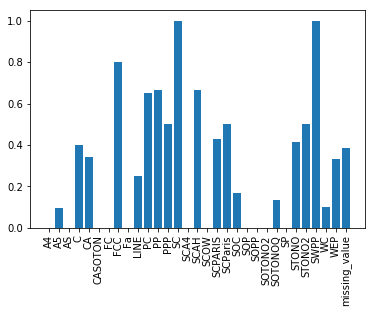

In [ ]:
plt.bar(df_ex.groupby('prefix').mean()['Survived'].index, df_ex.groupby('prefix').mean()['Survived'].values)
plt.xticks(rotation='vertical')
plt.show()

So, the prefix seems to be a good predictor of the survival of people. However, there are many labels. Let's group some labels together using k-means clustering algorithm using the Survival mean and the number of people per label to make the grouping. We'll group in 3 labels. 

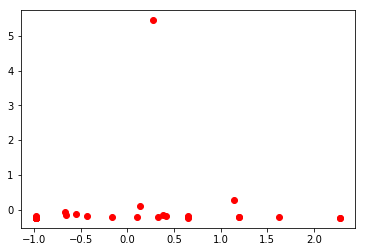

                      X         Y  label
prefix                                  
A4            -0.982387 -0.187279      2
A5            -0.671617 -0.066687      2
AS            -0.982387 -0.238961      2
C              0.322849 -0.204506      0
CA             0.131839  0.105587      0
CASOTON       -0.982387 -0.238961      2
FC            -0.982387 -0.238961      2
FCC            1.628085 -0.204506      0
Fa            -0.982387 -0.238961      2
LINE          -0.166615 -0.213120      2
PC             1.138622  0.269248      0
PP             1.193006 -0.221734      0
PPP            0.649158 -0.230347      0
SC             2.280703 -0.238961      0
SCA4          -0.982387 -0.238961      2
SCAH           1.193006 -0.221734      0
SCOW          -0.982387 -0.238961      2
SCPARIS        0.416080 -0.187279      0
SCParis        0.649158 -0.213120      0
SOC           -0.438539 -0.195893      2
SOP           -0.982387 -0.238961      2
SOPP          -0.982387 -0.221734      2
SOTONO2       -0

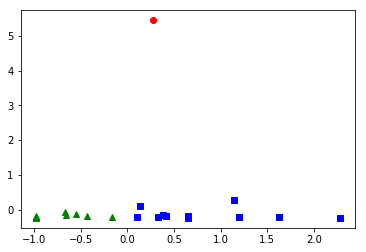

In [ ]:
#mean per label
X = df_ex.groupby('prefix').mean()['Survived']
# count per label
Y = df_ex.groupby('prefix').count()['Survived']

#normalization 
X = (X - np.mean(X))/np.std(X)
Y = (Y - np.mean(Y))/np.std(Y)

array = np.array([[X[i], Y[i]] for i in range(len(X))])
plt.plot(X,Y, 'ro')
plt.show()

#k-means clustering 
kmeans = KMeans(n_clusters=3, random_state=0).fit(array)
df_clusters = pd.DataFrame(array, columns = ['X', 'Y'])
df_clusters['label'] = kmeans.labels_
df_clusters.index = df_ex.groupby('prefix').mean().index
print(df_clusters)

#group plotting 

for i in range(len(df_clusters)):
    point = [df_clusters.X.iloc[i], df_clusters.Y.iloc[i]]
    if df_clusters.label.iloc[i] == 0:
        plt.plot(point[0], point[1], 'bs')
    elif df_clusters.label.iloc[i] == 1:
        plt.plot(point[0], point[1], 'ro')
    elif df_clusters.label.iloc[i] == 2:
        plt.plot(point[0], point[1], 'g^')
plt.show()

In [ ]:
mapping_dict = dict()

list_cat = df_ex.groupby('prefix').mean().index
list_label = kmeans.labels_

for i in range(len(list_cat)):
    mapping_dict[list_cat[i]] = list_label[i]
mapping_dict
mapping_dict_2 = {2:'Prefix_2', 1:'Prefix_1', 0:'Prefix_0'}

#the second mapping converts into strings which let sklearn converts this variable into dummies later

df_ex.prefix = df_ex.prefix.map(mapping_dict).map(mapping_dict_2)
df_ex.groupby('prefix').mean()


,Survived
prefix,
Prefix_0,0.525974
Prefix_1,0.384266
Prefix_2,0.092105


We can see that the average survival is well distinguished between the labels. 

In [ ]:
#operations on the real datasets


df['prefix'] = df.apply(lambda x: get_prefix(x['Ticket']), axis=1)
df.prefix = df.prefix.map(mapping_dict).map(mapping_dict_2)

df_test['prefix'] = df_test.apply(lambda x: get_prefix(x['Ticket']), axis=1)
df_test.prefix = df_test.prefix.map(mapping_dict).map(mapping_dict_2)

df.drop('Ticket', axis = 1, inplace=True)
df_test.drop('Ticket', axis = 1, inplace=True)

## Fare

First of all, we remember, there was missing 1 fare data in the test set. Let's replace it. 

In [ ]:
mean = df.Fare.mean()
df_test.Fare = df_test.Fare.fillna(mean)

In [ ]:
df_test.isnull().sum()

Pclass          0
Sex             0
Age             0
Fare            0
Cabin         327
Embarked        0
Title           0
FamilyType      0
prefix          6
dtype: int64

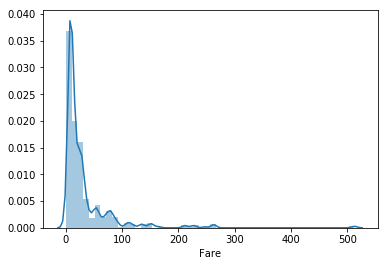

In [ ]:
sns.distplot(df.Fare)

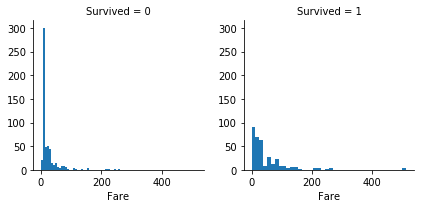

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Fare', bins=40))

Low fare people are less likely to survive. So we should keep this feature. However, the distribution is skewed and we'll apply the [Box-Cox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) transform to map the data to a Normal distribution. <br>

Lambda: 0.225029


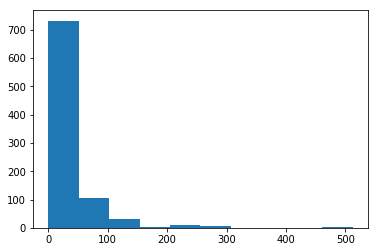

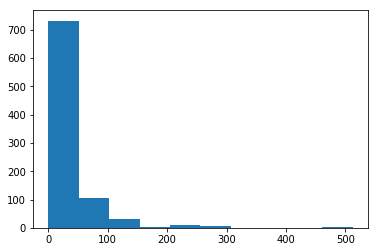

In [ ]:
#we use the training dataset to estimate the box cox coefficient

df['Fare2'], lam_fare = boxcox(df['Fare']+0.0001)
print('Lambda: %f' % lam_fare)

# histogram
pyplot.hist(df['Fare'])
pyplot.show()

pyplot.hist(df['Fare'])
pyplot.show()

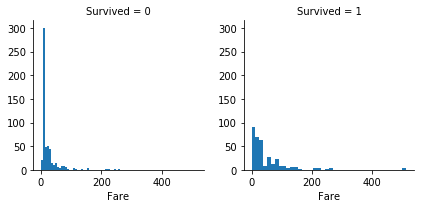

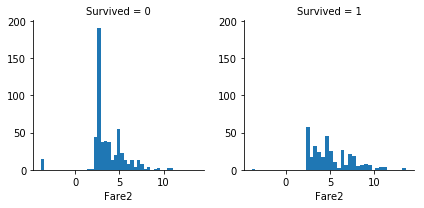

In [ ]:
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Fare', bins=40))
num = sns.FacetGrid(df, col='Survived')
print(num.map(plt.hist, 'Fare2', bins=40))
df.drop(['Fare2'], axis=1, inplace= True)

In [ ]:
#here we apply the transformation to the 2 datasets.

def get_transform(var):
    return (var**lam_fare - 1) / lam_fare

df['Fare'] = df.apply(lambda x: get_transform(x.Fare),axis=1)
df_test['Fare'] = df_test.apply(lambda x: get_transform(x.Fare),axis=1)


## Cabin

As seen before, let's see if we can engineer some informations from this feature. 

In [ ]:
df_ex = df.copy()
df_ex.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
       'Title', 'FamilyType', 'prefix'],
      dtype='object')

In [ ]:
df_ex = df_ex[['Survived', 'Cabin']]

def get_has_cabin(var):
    """
    This function checks if a value is Null or not.
    if yes, it means the passenger has no ticket information 
    if no, then it returns the letter of the ticket 
    """
    if var != var:
        return 'missing_value'
    else:
        return var[0]

df_ex['cabin_letter'] = df_ex.apply(lambda x: get_has_cabin(x['Cabin']), axis=1)

In [ ]:
df_ex.groupby('cabin_letter').mean()

,Survived
cabin_letter,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
missing_value,0.299854


At a first glance, the type of cabin seems to bring information. The type of cabin has a lot of different survival rate. 

However, the number of category is important. Let's group the labels together. We can identify several groups.

To do so, we'll cluster the categories following the survival rate variable into 3 groups.

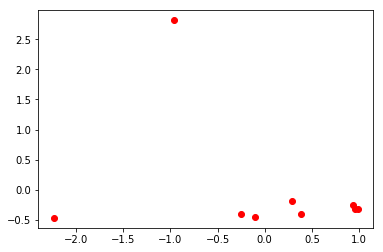

                      X         Y  label
cabin_letter                            
A             -0.249575 -0.402506      0
B              0.934516 -0.249170      0
C              0.289430 -0.191669      0
D              0.989437 -0.316254      0
E              0.957171 -0.321046      0
F              0.383830 -0.412089      0
G             -0.107605 -0.455215      0
T             -2.237157 -0.469590      2
missing_value -0.960046  2.817539      1


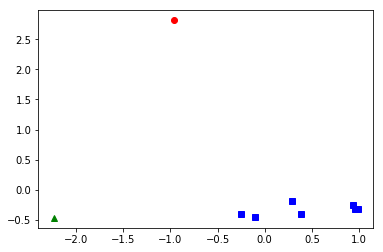

In [ ]:
X = df_ex.groupby('cabin_letter').mean()['Survived']
Y = df_ex.groupby('cabin_letter').count()['Survived']

#normalization 
X = (X - np.mean(X))/np.std(X)
Y = (Y - np.mean(Y))/np.std(Y)

array = np.array([[X[i], Y[i]] for i in range(len(X))])
plt.plot(X,Y, 'ro')
plt.show()
kmeans = KMeans(n_clusters=3, random_state=0).fit(array)
df_clusters = pd.DataFrame(array, columns = ['X', 'Y'])
df_clusters['label'] = kmeans.labels_
df_clusters.index = df_ex.groupby('cabin_letter').mean().index
print(df_clusters)
for i in range(len(df_clusters)):
    point = [df_clusters.X.iloc[i], df_clusters.Y.iloc[i]]
    if df_clusters.label.iloc[i] == 0:
        plt.plot(point[0], point[1], 'bs')
    elif df_clusters.label.iloc[i] == 1:
        plt.plot(point[0], point[1], 'ro')
    elif df_clusters.label.iloc[i] == 2:
        plt.plot(point[0], point[1], 'g^')
plt.show()


The labels are converted into 3 labels. Let's define the mapping dictionnary to use later in order to engineer this feature.

In [ ]:
mapping_dict = dict()

list_cat = df_ex.groupby('cabin_letter').mean().index
list_label = kmeans.labels_

for i in range(len(list_cat)):
    mapping_dict[list_cat[i]] = list_label[i]
mapping_dict
mapping_dict_2 = {2:'Cab_2', 1:'Cab_1', 0:'Cab_0'}

#the second mapping converts into strings which let sklearn converts this variable into dummies later

df_ex.cabin_letter = df_ex.cabin_letter.map(mapping_dict).map(mapping_dict_2)
df_ex.groupby('cabin_letter').mean()


,Survived
cabin_letter,
Cab_0,0.669951
Cab_1,0.299854
Cab_2,0.000000


In [ ]:
df['cabin_letter'] = df.apply(lambda x: get_has_cabin(x['Cabin']), axis=1)
df.cabin_letter = df.cabin_letter.map(mapping_dict).map(mapping_dict_2)

df_test['cabin_letter'] = df_test.apply(lambda x: get_has_cabin(x['Cabin']), axis=1)
df_test.cabin_letter = df_test.cabin_letter.map(mapping_dict).map(mapping_dict_2)

df.drop('Cabin', axis=1, inplace = True)
df_test.drop('Cabin', axis=1, inplace = True)

## Embarked

As seen before, we'll use  [one-hot encoding](https://fr.wikipedia.org/wiki/Encodage_one-hot).

## One hot-encoding

Then we need to encode this feature using [one-hot encoding](https://fr.wikipedia.org/wiki/Encodage_one-hot). Indeed, there is no assumed order between the different categories. We drop first column to avoid "statistically/informationally redundant" information. 

In [ ]:
df = pd.get_dummies(df, prefix = 'cat', drop_first=True)
df_test = pd.get_dummies(df_test, prefix = 'cat', drop_first=True)


# Model

In [ ]:
#preparation of the data

Y_train = df['Survived']
X_train = df.drop('Survived', axis=1)


X_test = df_test

## Selection of the best models

I will compare different algorithm using [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). <br>
K-fold is important here (in the case of a small dataset) because it enables us to train/test the model 10 times and then we can reduce the chance of over-fitting or even luck.
The models tried for this bi-label classification problem will be:
- Logistic Regression
- Decision Tree
- Random Forest
- SVM
- ExtraTree
- Gradient Boosting
- AdaBoost
- KNN 
- XGBoost

In [ ]:
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.svm import SVC, LinearSVC, NuSVC

In [ ]:
models = list()


#here is the list of the models we'll try 

models.append(LogisticRegression())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(SVC())
models.append(ExtraTreesClassifier())
models.append(GradientBoostingClassifier())
models.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
models.append(KNeighborsClassifier())
models.append(XGBClassifier())





In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

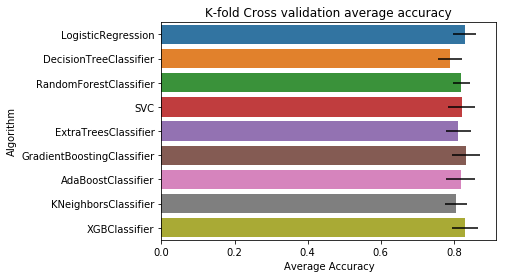

In [ ]:
cv_results = []
cv_names = []

for model in models :
    #print('go:', model)
    cv_results.append(cross_val_score(model, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    cv_names.append(model.__class__.__name__)
    #print('end:', model)

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":cv_names})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
g.set_xlabel("Average Accuracy")
g = g.set_title("K-fold Cross validation average accuracy")



    

The different algorithm performs differently. We need to look at the average, but also at the standard deviation of the accuracy of these algorithms. Indeed, we want our model to perform well on average, but we don't want it to perform really poorly sometimes or really greatly on other times. <br>
I decided to use a hand-crafted criterion in order to take into account both average and deviation. The criterion is defined as the average minus the half of the deviation. So we take the algorithm with the best accuracy modulated by a not to big deviation. 

In [ ]:
cv_res['criterion'] = cv_res.CrossValMeans - cv_res.CrossValerrors/2

In [ ]:
cv_res.sort_values(by='criterion', ascending=False)

,Algorithm,CrossValMeans,CrossValerrors,criterion
5,GradientBoostingClassifier,0.833942,0.038665,0.814609
0,LogisticRegression,0.829422,0.030354,0.814245
8,XGBClassifier,0.830583,0.035411,0.812877
2,RandomForestClassifier,0.820470,0.023704,0.808618
3,SVC,0.821569,0.036976,0.803081
6,AdaBoostClassifier,0.819296,0.039934,0.799329
4,ExtraTreesClassifier,0.812567,0.034366,0.795384
7,KNeighborsClassifier,0.807049,0.029745,0.792177
1,DecisionTreeClassifier,0.783352,0.034692,0.766006


Gradient Boosting produces the best outcome in terms of criterion. We can directly use it to produce the submission file. <br>
Or we can decide to use different models and ensemble the results in order to produce a better outcome: this method is so-called 'Ensemble modeling'.<br>
To select the best ones, I use a criterion which is the mean of the accuracy minus the half of the standard deviation of the accuracy. <br>
But first, let's select the 5 best algorithms in order to perform hyper-parameters optimization:
- LogisticRegression
- GradientBoosting
- XGBoost
- SVM
- RandomForest	

## Hyper-parameter optimization

In this part, I try to improve the accuracy of the selected classifiers by hyper-parameters optimization. To do so, I use a Scikit-Learn implemented tool in order to perform a grid search. 

Watch-out: This is a long process, you can use multi-cpu to speed-up the computation.

In [ ]:
# Logistic Regression Parameters tunning
LR = LogisticRegression( )

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-2, 2, 100)


lr_param_grid = {'penalty': penalty, 'C': C }

clf = GridSearchCV(LogisticRegression(), lr_param_grid)

gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# View best hyperparameters
print('Best Penalty:', LR_best.get_params()['penalty'])
print('Best C:', LR_best.get_params()['C'])

# Best score
gsLR.best_score_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Done 1024 tasks      | elapsed:    3.0s


Best Penalty: l2
Best C: 12.91549665014884


[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   14.7s finished


0.8338945005611672

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1400, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())


# Best score
gsRFC.best_score_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 10.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 14.2min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 20.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 27.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 48.4min
[Parallel(n_jobs=4)]: Done 3840 out of 3840 | elapsed: 68.1min finished


{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


0.8395061728395061

In [ ]:
# Gradient boosting tunning tttttt


#shrinks the contribution of each tree by learning_rate.
learning_rates = [1, 0.25, 0.1, 0.05, 0.01]
#the number of trees in the forest
n_estimators = [1, 2, 4,  32, 100, 150, 200,  300]
# how deep the built tree can be
max_depths = np.linspace(1, 32, 8, endpoint=True)

#minimum number of samples required to be at a leaf node.
min_samples_leafs =  np.linspace(0.1, 0.5, 4, endpoint=True)
#represents the number of features to consider when looking for the best split
max_features = [0.5, 0.3, 0.1]

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : n_estimators,
              'learning_rate': learning_rates,
              'max_depth': max_depths,
              'min_samples_leaf': min_samples_leafs,
              'max_features': max_features
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

print(GBC_best.get_params())


# Best score
gsGBC.best_score_

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


[Parallel(n_jobs=4)]: Done 512 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 1192 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 1837 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 2841 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 4277 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 5809 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 7300 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 9187 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 11994 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done 14541 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 18228 tasks      | elapsed: 13.6min
[Parallel(n_jobs=4)]: Done 21300 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 24420 tasks      | elapsed: 18.3min
[Parallel(n_jobs=4)]: Done 28092 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done 34032 tasks      | elapsed: 23.8min
[Parallel(n_jobs=4)]: Done 38400 out of 38400 | elapsed: 25.9min

{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 1, 'loss': 'deviance', 'max_depth': 18.714285714285715, 'max_features': 0.1, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


0.8451178451178452

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)

Cs = [0.001, 0.01, 0.1, 1, 10, 50, 100,200,300, 1000, 3000]
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ]
    
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': gammas,
                  'C': Cs}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

print(SVMC_best.get_params())


# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 66 candidates, totalling 660 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 660 out of 660 | elapsed:  1.2min finished


{'C': 1000, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


0.8305274971941639

In [ ]:
### XGB classifier

XGB = XGBClassifier()



max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 

gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

XGB_param_grid = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = GridSearchCV(estimator = XGB, 
                    param_grid = XGB_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# target = 'AntAktAvtBank'
# predictors = [x for x in dtrain.columns if x not in [target, ID_col]]
# gsearch1.fit(dtrain[predictors],dtrain[target])
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 3125 candidates, totalling 31250 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   42.6s
[Parallel(n_jobs=4)]: Done 3144 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 4944 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 7144 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 9744 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 12744 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 16144 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 19068 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 22620 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done 25726 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done 28226 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done 30163 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 31243 out of 31250 | elapsed: 21.6min remaining:    0.3s
[Parallel(n_jobs=4)]: Done 31250 out of 312

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.625, 'gamma': 0.5, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 3.25, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.5}


0.8462401795735129

## Ensemble Modeling 

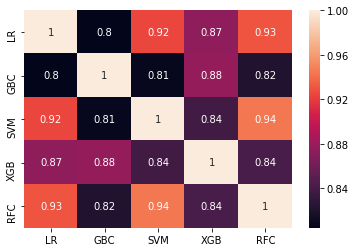

In [ ]:
test_Survived_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")
test_Survived_SVM = pd.Series(SVMC_best.predict(X_test), name="SVM")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_LR,test_Survived_GBC,test_Survived_SVM, test_Survived_XGB, test_Survived_RFC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
print('test score LR:', gsLR.best_score_)
print('test score RFC:', gsRFC.best_score_)
print('test score GBC:', gsGBC.best_score_)
print('test score SVMC:', gsSVMC.best_score_)
print('test score XGB:', gsXGB.best_score_)
print('test score ADA:', gsadaDTC.best_score_)

test score LR: 0.8338945005611672
test score RFC: 0.8395061728395061
test score GBC: 0.8451178451178452
test score SVMC: 0.8305274971941639
test score XGB: 0.8462401795735129
test score ADA: 0.8282828282828283


The classifier are quiet correlated. This is a good sign! However we observe some differences between the 5 classifiers. This is good for you because we can leverage the use of a voting system to improve our prediction.

In [ ]:
#here I use the soft rule as voting rule because it produced a better score on Kaggle rather than the hard rule. 

votingC = VotingClassifier(estimators=[('LR', LR_best), 
('GBC', GBC_best), ('SVM',SVMC_best), ('XGB',XGB_best), ("RandomForest",RFC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

# Submission

In [ ]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")

In [ ]:


ids = pd.read_csv('./data/'+ 'test.csv')['PassengerId']

predictions = votingC.predict(X_test)


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

- k fold instead 
- ajouter cabin et ticket
- vizu
- automatiser les tests des models: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [ ]:
# integrer HP opti
#https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy